In [1]:
import os
from os import path
import pandas as pd
import numpy as np
from tqdm import tqdm
from scipy import io
import scipy as scipy
import collections
import scipy.sparse as sp_sparse
import tables
import time
import numba as nb
from numba import config
from numba_progress import ProgressBar
import ipdb
import matplotlib as plt
from tqdm.notebook import tqdm
from numba.typed import Dict
from scipy import sparse


from ABCA7lof2.setup import get_data, save_all, save_annotations, subset_mat
from ABCA7lof2.qc import filter_cells, filter_cells_by_major_annotation, filter_on_gaussian_logliklihood, get_total_counts, log_normalize_counts, get_fraction_mito

from ABCA7lof2.annotation import get_major_annotations
from ABCA7lof2.singlecell import bulk_data, expressed_fraction

config.THREADING_LAYER = 'workqueue'

In [2]:
# define paths
meta_path = './raw_data/cellranger_counts_out/aggr_out/metadata.npy'
features_name_path = './raw_data/cellranger_counts_out/aggr_out/features_name.npy'
matrix_path = './raw_data/cellranger_counts_out/aggr_out/counts.npy'
features_id_path = './raw_data/cellranger_counts_out/aggr_out/features_id.npy'
barcodes_path = './raw_data/cellranger_counts_out/aggr_out/barcodes.npy'

# load data
counts = np.lib.format.open_memmap(matrix_path, mode='r')
features_name = np.lib.format.open_memmap(features_name_path, mode='r')
features_id = np.lib.format.open_memmap(features_id_path, mode='r')
barcodes = np.lib.format.open_memmap(barcodes_path, mode='r')
meta = np.load(meta_path, allow_pickle=True)

# get column names
meta_col_names = np.array(pd.read_csv('./raw_data/metadata/single_cell_individual_metadata.csv', index_col=0).columns)

# run checks
temp = features_name.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature names were aggregated correctly across samples.')
    
temp = features_id.reshape((len(np.unique(meta[:,1])), counts.shape[1]))
if np.unique([np.array_equal(temp[0], x) for x in temp])[0]:
    print('Feature IDs were aggregated correctly across samples.')
    
# concatenate features and metadata
features = np.concatenate((features_name[:counts.shape[1]].reshape(-1,1), features_id[:counts.shape[1]].reshape(-1,1)), axis=1)
meta = np.concatenate((barcodes.reshape(-1,1), meta), axis=1)


Feature names were aggregated correctly across samples.
Feature IDs were aggregated correctly across samples.


In [ ]:
# run initial cell filtering
mito_index, total_counts, mito_fractions, filtered_meta, filtered_counts  = filter_cells(features[:,0], counts, meta, 1, 500, 10000, plt.backends.backend_pdf.PdfPages('./pdf_figures/single_cell_qc.pdf'), 'MT-', './processed_data/single_cell')

getting mito fractions


In [3]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
import pandas as pd

mito_fractions, mito_index, total_counts = get_fraction_mito(features[:,0], counts, 'MT-')
X  = np.log10(mito_fractions+2e-05).reshape(-1,1)

# this code is from: https://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_selection.html#sphx-glr-auto-examples-mixture-plot-gmm-selection-py

def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)


param_grid = {
    "n_components": range(1, 15),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}
grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)
grid_search.fit(X)


df = pd.DataFrame(grid_search.cv_results_)[
    ["param_n_components", "param_covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_n_components": "Number of components",
        "param_covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)

###############

x = df.loc[np.argmin(df['BIC score'])]
gm = GaussianMixture(n_components=x[0], max_iter=10000, n_init=100, covariance_type=x[1]).fit(temp)
labels = gm.predict(temp)
clust_remove = np.argmax([np.mean(temp[labels==x]) for x in np.unique(labels)])

In [3]:
@nb.njit(parallel=True)
def get_N_detected_genes(counts, N, progress_hook):
    for i in nb.prange(len(counts)):
        N[i] = sum(counts[i]>0)
        progress_hook.update(1)

In [8]:
with ProgressBar(total=counts.shape[0]) as numba_progress:
    N = np.empty(len(counts))
    get_N_detected_genes(counts, N, numba_progress)

  0%|          | 0/150456 [00:00<?, ?it/s]

In [13]:
(N>=500)+(N<=10000)

array([ True,  True,  True, ...,  True,  True,  True])

In [16]:
np.array([True,False])&np.array([True,True])

array([ True, False])

In [ ]:
N

In [ ]:
get_N_detected_genes(counts, N)

In [99]:
len(counts)

150456

In [62]:

df.sort_values(by="BIC score").head()


,Number of components,Type of covariance,BIC score
4,5,spherical,64357.036160
46,5,full,64372.452457
32,5,diag,64377.055123
33,6,diag,64385.531608
47,6,full,64392.644337


/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/seaborn/axisgrid.py:88: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


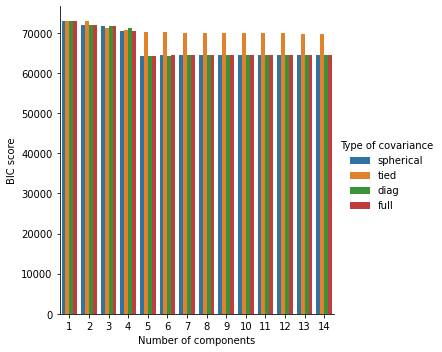

In [63]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.pyplot.show()

In [68]:
df.loc[np.argmin(df['BIC score'])]

Number of components              5
Type of covariance        spherical
BIC score               64357.03616
Name: 4, dtype: object

In [69]:
gm = GaussianMixture(n_components=5,max_iter=10000, n_init=100, covariance_type='spherical').fit(temp)
labels = gm.predict(temp)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f637326fe50>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

In [81]:
clust_remove = np.argmax([np.mean(temp[labels==x]) for x in np.unique(labels)])

(array([8395., 3624., 2021., 1188.,  840.,  502.,  303.,  199.,  105.,
          26.]),
 array([0.07224835, 0.15877724, 0.24530612, 0.331835  , 0.41836388,
        0.50489277, 0.59142165, 0.67795053, 0.76447941, 0.8510083 ,
        0.93753718]),
 <BarContainer object of 10 artists>)

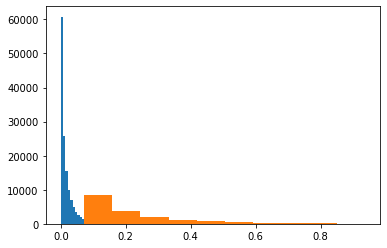

In [87]:
plt.pyplot.hist(mito_fractions[labels!=clust_remove])
plt.pyplot.hist(mito_fractions[labels==clust_remove])

In [80]:
np.unique(labels)

array([0, 1, 2, 3, 4])

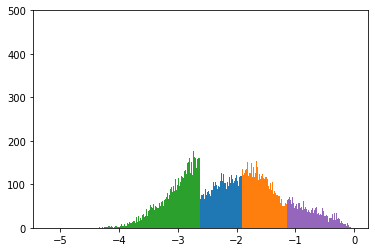

In [73]:
for i in range(len(np.unique(labels))):
    plt.pyplot.hist(temp[labels==i],500)
plt.pyplot.ylim(0,500)
None


In [5]:
from sklearn.mixture import GaussianMixture


In [71]:
from sklearn.cluster import SpectralClustering

In [51]:
temp = np.log10(mito_fractions+2e-05).reshape(-1,1)
gm = GaussianMixture(n_components=3,max_iter=10000, n_init=100, covariance_type='full').fit(temp)
labels = gm.predict(temp)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f64bc95eb80>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

In [44]:
np.sum(labels)

123496

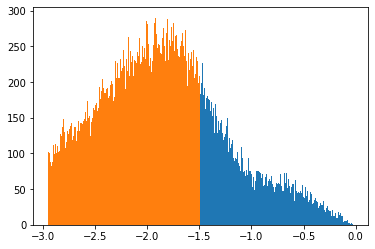

In [52]:
plt.pyplot.hist(temp[labels==1], 500)
plt.pyplot.hist(temp[labels==0], 500)

None

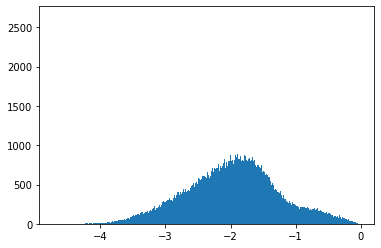

In [34]:
plt.pyplot.hist(temp, 500)
None

In [32]:
np.sum(labels!=3)

135526

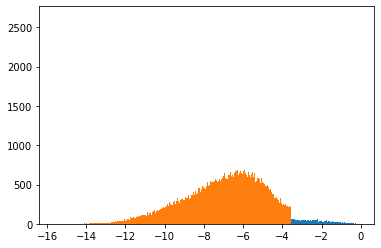

In [30]:
plt.pyplot.hist(temp[labels==3],500)
plt.pyplot.hist(temp[labels!=3],500)

None

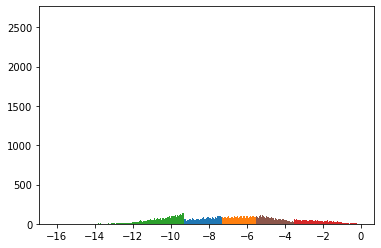

In [15]:
for i in range(len(np.unique(labels))):
    plt.pyplot.hist(temp[labels==i],500)

None


In [ ]:
clustering = SpectralClustering(n_clusters=2,
        assign_labels='discretize',
        random_state=0).fit(temp)

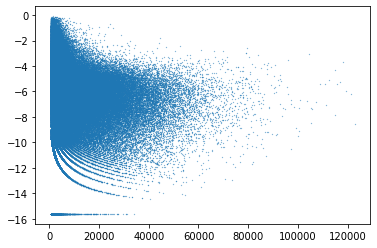

In [66]:
plt.pyplot.scatter(total_counts, temp, s=0.05)

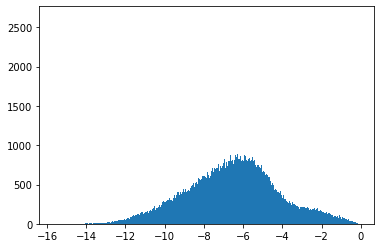

In [61]:
plt.pyplot.hist(temp, 500)
None

In [56]:
np.sum(labels!=3)

130177

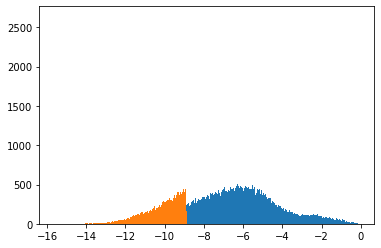

In [68]:
plt.pyplot.hist(temp[labels==1],500)
plt.pyplot.hist(temp[labels==0],500)



None


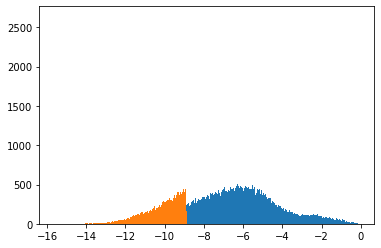

In [36]:
plt.pyplot.hist(temp[labels==1], 500)
plt.pyplot.hist(temp[labels==0], 500)

None

In [25]:
np.min(mito_fractions[mito_fractions>0])

2.45935909102088e-05

In [4]:
#annotating major cell types
annotations, marker_out, projected_matrix, predict, scores, marker_genes, marker_indices = get_major_annotations('./processed_data/single_cell/brain_marker_genes.csv', features[:,0], filtered_counts, total_counts, 1, 50, 10, './processed_data/single_cell', None)

using prior markers for reduction & annotation...
getting marker indices...
getting normalized marker matrix...


  0%|          | 0/124282 [00:00<?, ?it/s]

running pca...


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fe5c5400670>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


estimating gaussian mixture model...
computing celltype summary scores...
annotating cell types...


In [5]:
print('filtering by logliklihood')
keep_cells_1 = filter_on_gaussian_logliklihood(scores)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed6b5639d0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


filtering by logliklihood


In [6]:
individual_annotation = filtered_meta[:,2]
keep_cells_2, keep_cells_mito, keep_cells_individual, keep_genes, keep_individuals = filter_cells_by_major_annotation(mito_fractions, total_counts, 1, predict, individual_annotation, filtered_counts)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed520cb5e0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'


Filtering Cells by major annotation.


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed6b563d30>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

Labels = [0 1]
counts per label = [ 9164 24208]
Labels = [0 1]
counts per label = [8685 4843]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed6b563ee0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

Labels = [0 1]
counts per label = [858 708]
Labels = [0 1]
counts per label = [28312  6019]
Labels = [0 1]
counts per label = [144  87]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed520cb5e0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

Labels = [0 1]
counts per label = [627 243]
Labels = [0 1]
counts per label = [4744 2760]


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fed6b563ee0>
Traceback (most recent call last):
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/state/partition1/llgrid/pkg/anaconda/anaconda3-2022a/lib/python3.8/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exce

Labels = [0 1]
counts per label = [5262 1560]
Labels = [0 1]
counts per label = [12777  3780]
Labels = [0 1]
counts per label = [2537 6964]


  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

  0%|          | 0/36601 [00:00<?, ?it/s]

In [7]:
# compile metadata
filtered_meta_final = np.concatenate((filtered_meta,(keep_cells_1&keep_cells_2).reshape(-1,1), keep_cells_mito.reshape(-1,1), keep_cells_individual.reshape(-1,1), (scores>90).reshape(-1,1), predict.reshape(-1,1), scores.reshape(-1,1), annotations.reshape(-1,1), total_counts.reshape(-1,1), mito_fractions.reshape(-1,1)), axis = 1)
meta_names = np.concatenate((np.concatenate((np.array(['barcodes','index']), meta_col_names), axis=0), np.array(('keep_cells_all_per_celltype', 'keep_cells_mito_per_celltype', 'keep_cells_individual', 'keep_cells_gaussian', 'predictions', 'gaussian_liklihood', 'annotations', 'total_counts', 'mito_fractions'))), axis = 0)

In [8]:
# save data
np.save('./processed_data/single_cell/filtered_meta.npy', filtered_meta_final)
np.save('./processed_data/single_cell/meta_names.npy', meta_names)
np.save('./processed_data/single_cell/features.npy', features)
np.save('./processed_data/single_cell/projected_matrix.npy', projected_matrix)
np.save('./processed_data/single_cell/marker_indices.npy', marker_indices)
np.save('./processed_data/single_cell/keep_genes.npy', keep_genes)

In [9]:
# normalize counts
logcounts = np.memmap('./processed_data/single_cell/filtered_logcounts.npy', mode='w+', shape=filtered_counts.shape, dtype='float')
log_normalize_counts(filtered_counts, total_counts, logcounts)

100%|██████████| 124282/124282 [01:39<00:00, 1243.94it/s]
